# Demo File
This demo tests the functionality of the EchoStateNetwork with different time series

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from ESN import EchoStateNetwork
from ESN import mackey_glass
from ESN import GinfActivator

ginf_activator = GinfActivator(V_min=-2, V_max=2, resolution=200, offset=True)

def mse(test, predictions):
    return np.mean((predictions[100:] - test[100:]) ** 2)

# Steady State Conductance Activator

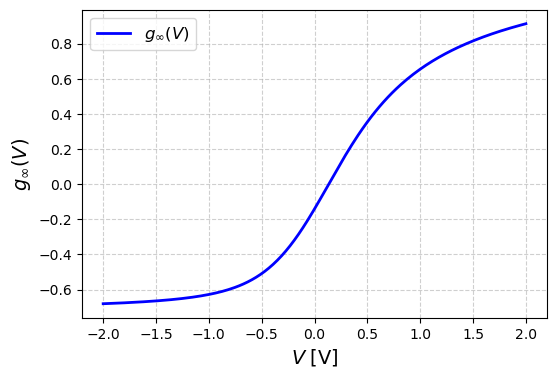

In [36]:
lookup_table = ginf_activator.get_lookup_table()

plt.figure(figsize=(6, 4))
plt.plot(lookup_table[0], lookup_table[1], label=r"$g_{\infty}(V)$", color="blue", linewidth=2)
plt.xlabel(r"$V \;[\text{V}]$", fontsize=14)
plt.ylabel(r"$g_{\infty}(V)$", fontsize=14)
#plt.title(r"$g_{\infty}(V) = \int_0^L g(x, V) \, dx$", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.savefig("output/ginf_activator_plot.pdf")
plt.savefig("output/ginf_activator_plot.png")

## ESN with Mackey-Glass time series

In [6]:
esn = EchoStateNetwork(
    input_dim=1,
    reservoir_size=3,
    output_dim=1,
    leaking_rate=1,
    step_size=0.3,
    time_scale=1,
    spectral_radius=1.2,
    sparsity=0.85,
    input_scaling=0.5,
    regularization=1e-6,
    activation=ginf_activator.activate,
)

In [8]:
# Generate Mackey-Glass time series
mg_series = mackey_glass(tau=15, n=10000, n_samples=5000)

# Normalize data between -1 and 1
mg_series = 2 * (mg_series - mg_series.min()) / (mg_series.max() - mg_series.min()) - 1

# Create input/output pairs for time series prediction
inputs = mg_series[:-1].reshape(-1, 1)
targets = mg_series[1:].reshape(-1, 1)

# Split into train and test sets
train_len = 4000
test_len = 1000
train_inputs = inputs[:train_len]
train_targets = targets[:train_len]
test_inputs = inputs[train_len : train_len + test_len]
test_targets = targets[train_len : train_len + test_len]

In [9]:
# Train on first part of series
esn.fit(train_inputs, train_targets, washout=200)

# Generate predictions on test set
predictions = esn.predict(test_inputs)

In [14]:
# Calculate prediction error after network settled from np.zeroes initialization
print(f"Test MSE: {mse(test_targets, predictions)}")

Test MSE: 0.0019301560686349523


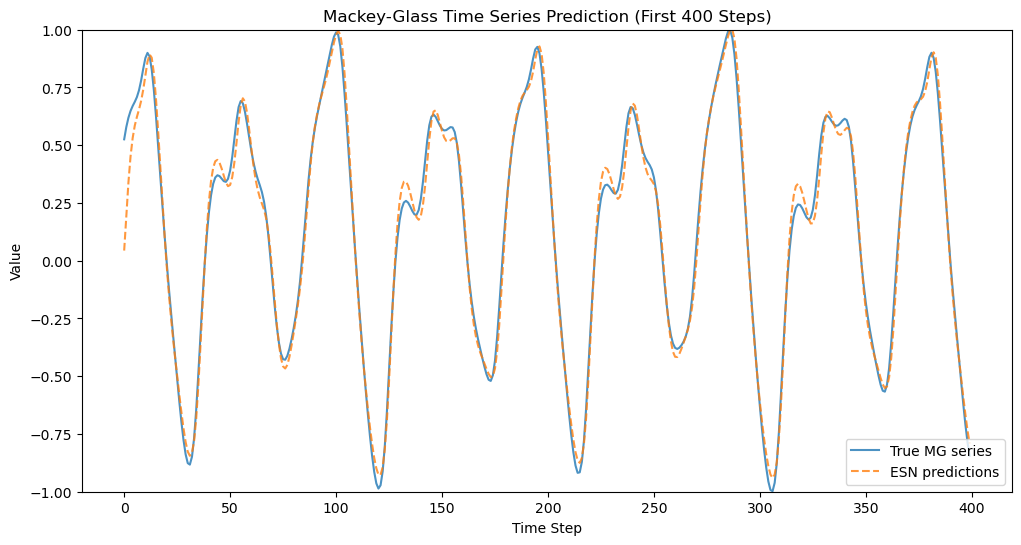

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(test_targets[:400], label="True MG series", alpha=0.8)
plt.plot(predictions[:400], label="ESN predictions", linestyle="--", alpha=0.8)
plt.title("Mackey-Glass Time Series Prediction (First 400 Steps)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.ylim(-1,1)
plt.legend()
plt.savefig("output/mg_prediction_plot.pdf")
plt.savefig("output/mg_prediction_plot.png")

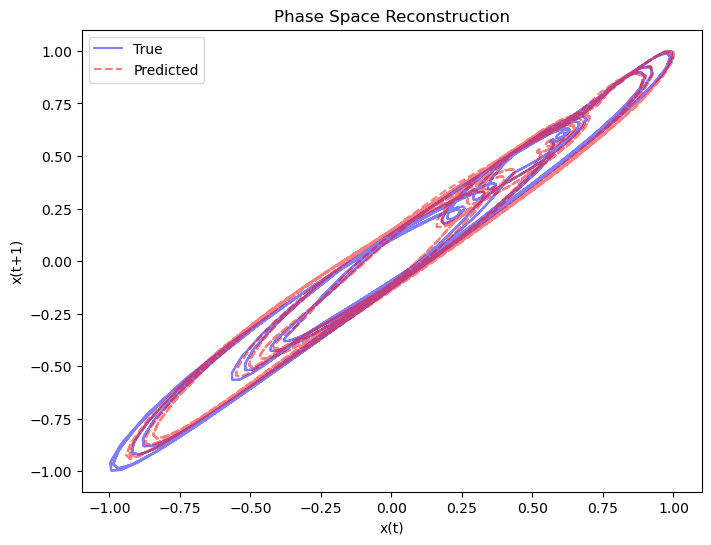

In [18]:
# Plot phase space reconstruction
plt.figure(figsize=(8, 6))
plt.plot(test_targets[:-1], test_targets[1:], "b-", alpha=0.5, label="True")
plt.plot(predictions[:-1], predictions[1:], "r--", alpha=0.5, label="Predicted")
plt.title("Phase Space Reconstruction")
plt.xlabel("x(t)")
plt.ylabel("x(t+1)")
plt.legend()
plt.savefig("output/mg_phase_space_plot.pdf")
plt.savefig("output/mg_phase_space_plot.png")

## ESN with Harmonic Wave time series

In [21]:
# Initialize and train ESN
esn = EchoStateNetwork(
    input_dim=1,
    reservoir_size=100,
    output_dim=1,
    leaking_rate=1,
    step_size=0.3,
    time_scale=1,
    spectral_radius=0.95,
    sparsity=0.7,
    input_scaling=1.0,
    regularization=1e-4,
    activation=np.tanh,
)

In [23]:
# Generate synthetic data (simple sine wave prediction)
t = np.linspace(0, 6 * np.pi, 1000)
data = np.sin(t) * np.cos(t) * t

# Create input/output pairs for time series prediction
inputs = data[:-1].reshape(-1, 1)
targets = data[1:].reshape(-1, 1)


In [25]:
# Train on synthetic data
esn.fit(inputs, targets, washout=100)

# Generate predictions
predictions = esn.predict(inputs)

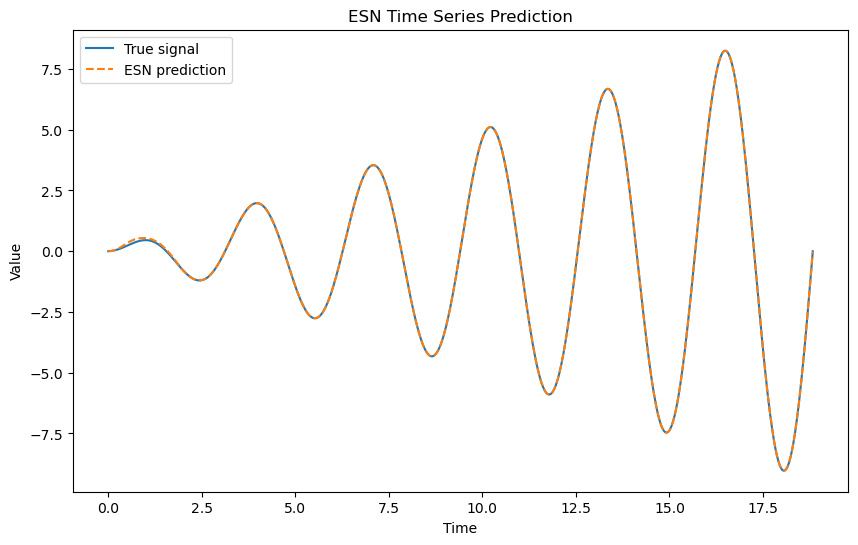

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(t[:-1], targets, label="True signal")
plt.plot(t[:-1], predictions, label="ESN prediction", linestyle="--")
plt.title("ESN Time Series Prediction")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.savefig("output/sine_prediction_plot.pdf")
plt.savefig("output/sine_prediction_plot.png")

# Optimize for MG Data

In [16]:
import optuna

def relu(x):
    return np.clip(x, 0, 2)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softsign(x):
    return x / (1 + np.abs(x))

activation_functions = {
    "tanh": np.tanh,
    "clip": relu,
    "leaky_relu": leaky_relu,
    "sigmoid": sigmoid,
    "softsign": softsign,
    "ginf": ginf_activator.activate
}

In [17]:
def objective(trial):
    tau = np.random.randint(10, 30)
    trial.set_user_attr("tau", tau)

    mg_series = mackey_glass(tau=tau, n=10000, n_samples=5000)
    mg_series = 2 * (mg_series - mg_series.min()) / (mg_series.max() - mg_series.min()) - 1

    inputs = mg_series[:-1].reshape(-1, 1)
    targets = mg_series[1:].reshape(-1, 1)

    train_len = 4000
    test_len = 1000
    train_inputs = inputs[:train_len]
    train_targets = targets[:train_len]
    test_inputs = inputs[train_len : train_len + test_len]
    test_targets = targets[train_len : train_len + test_len]

    reservoir_size = trial.suggest_int("reservoir_size", 1, 1000, log=True)
    leaking_rate = trial.suggest_float("leaking_rate", 0.01, 1.0)
    step_size = trial.suggest_float("step_size", 0.0001, 1, log=True)
    time_scale = trial.suggest_float("time_scale", 0.1, 5.0)
    spectral_radius = trial.suggest_float("spectral_radius", 0.1, 1.2)
    sparsity = trial.suggest_float("sparsity", 0.01, 0.99)
    input_scaling = trial.suggest_float("input_scaling", 0.1, 10.0, log=True)
    regularization = trial.suggest_float("regularization", 1e-6, 1e-2, log=True)

    activation_name = trial.suggest_categorical("activation", list(activation_functions.keys()))
    trial.set_user_attr("Activation name", activation_name)
    activation_func = activation_functions[activation_name]

    # Enforce the constraint before constructing the ESN
    if leaking_rate * (step_size / time_scale) > 1:
        raise optuna.exceptions.TrialPruned("Leaking rate * step_size/time_scale > 1")

    esn = EchoStateNetwork(
        input_dim=1,
        reservoir_size=reservoir_size,
        output_dim=1,
        leaking_rate=leaking_rate,
        step_size=step_size,
        time_scale=time_scale,
        spectral_radius=spectral_radius,
        sparsity=sparsity,
        input_scaling=input_scaling,
        regularization=regularization,
        activation=activation_func,
    )
    esn.fit(train_inputs, train_targets, washout=200)

    predictions = esn.predict(test_inputs)
    loss = mse(test_targets, predictions)
    return min(loss, 1)

In [18]:
try:
    study_name="ESN optimization MG 🔥"
    storage="sqlite:///optuna_esn_MG.db"

    optuna.delete_study(study_name=study_name, storage=storage)
except Exception:
    print("No database available")

optuna-dashboard sqlite:///optuna_esn_MG.db

In [ ]:
study = optuna.create_study(
    direction="minimize",
    study_name=study_name,
    storage=storage,
    load_if_exists=True,
)
study.optimize(objective, n_trials=1024, n_jobs=-1)

best_params = study.best_params
print("Best Hyperparameters:", best_params)